# PLS Regression
I'm following this paper: <https://www.sciencedirect.com/science/article/pii/S1878929316301074?via%3Dihub>

In [2]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (10, 10)})
sns.set_style("whitegrid")

## Get Data

In [18]:
from common.data import get_data

X, y, ages = get_data()

selected_measure = "WISC_FSIQ"
y = np.array(y[selected_measure])

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (577, 34716) y shape: (577,)


In [25]:
from sklearn.utils import shuffle

X, y = shuffle(X, y)

X_temp, y_temp = [], []
for i in range(0, len(X), 6):
    start = i
    end = i + 6
    if end > len(X):
        break
    X_temp.append(np.mean(X[start:end], axis=0))
    y_temp.append(np.mean(y[start:end]))

X_group, y_group = np.array(X_temp), np.array(y_temp)
print("X shape:", X_group.shape, "y shape:", y_group.shape)

X shape: (96, 34716) y shape: (96,)


In [ ]:
X_noise, y_noise

## Feature selection

In [5]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

### Age Binning

In [4]:
from common.age_bin import bin_by_age

bin_1, bin_2, bin_3 = bin_by_age(X, y, ages)

print("Bin 1:", len(bin_1.X), "|", "Bin 2:", len(bin_2.X), "|", "Bin 3:", len(bin_3.X))

Bin 1: 175 | Bin 2: 202 | Bin 3: 200


### Mutual Information

**MI Connections (All Ages)**

In [30]:
mi = SelectKBest(mutual_info_regression, k=1500)
# X = mi.fit_transform(X, y)
X_group = mi.fit_transform(X_group, y_group)
print("X shape:", X.shape)

X shape: (96, 1500)


**MI Connections (Age Bins)**

In [ ]:
mi_bin_1 = SelectKBest(mutual_info_regression, k=2500)
X_bin_1_mi = mi_bin_1.fit_transform(X_bin_1, y_bin_1)

mi_bin_2 = SelectKBest(mutual_info_regression, k=2000)
X_bin_2_mi = mi_bin_2.fit_transform(X_bin_2, y_bin_2)

mi_bin_3 = SelectKBest(mutual_info_regression, k=500)
X_bin_3_mi = mi_bin_3.fit_transform(X_bin_3, y_bin_3)

print("X_bin_1 shape:", X_bin_1_mi.shape, "X_bin_2 shape:", X_bin_2_mi.shape,
      "X_bin_3 shape:", X_bin_3_mi.shape)

## Train PLS Regression

### Determine optimal number of components

In [7]:
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score

In [28]:
num_component = 2
kf = KFold(n_splits=10)
train_scores = []
test_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pls = PLSRegression(n_components=num_component)
    pls.fit(X_train, y_train)
    
    train_scores.append(pls.score(X_train, y_train))
    test_scores.append(pls.score(X_test, y_test))

print("Avg train score:", np.mean(train_scores))
print("Avg test score:", np.mean(test_scores))

Avg train score: 0.6778868999558385
Avg test score: -0.26460093844885524


### Use PLS to predict scores

In [38]:
train_scores = []
test_scores = []
coefs = []

for i in range(0, 1000):
    X_train, X_test, y_train, y_test = train_test_split(
        X_group, y_group, test_size=0.1)
    
    pls = PLSRegression(n_components=num_component)
    pls.fit(X_train, y_train)

    y_train_pred = pls.predict(X_train)
    y_test_pred = pls.predict(X_test)
    
    train_scores.append(r2_score(y_train, y_train_pred))
    test_scores.append(r2_score(y_test, y_test_pred))
    coefs.append(pls.coef_)

avg_train_score = np.mean(train_scores)
avg_test_score = np.mean(test_scores)
avg_coef = np.mean(coefs, axis=0)

print("Train r^2:", avg_train_score)
print("Test r^2:", avg_test_score)

Train r^2: 0.678747487711667
Test r^2: 0.1288965750828533


In [131]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lin_reg_train = LinearRegression().fit(y_train, y_train_pred)
y_train_pred_lin_reg = lin_reg_train.predict(y_train)

lin_reg_test = LinearRegression().fit(y_test, y_test_pred)
y_test_pred_lin_reg = lin_reg_test.predict(y_test)

lin_reg_train_score = lin_reg_train.score(y_train, y_train_pred)
lin_reg_test_score = lin_reg_test.score(y_test, y_test_pred)
print("Train r^2:", lin_reg_train_score)
print("Test r^2:", lin_reg_test_score)

Train r^2: 0.34289127736294345
Test r^2: 0.07290508804920548


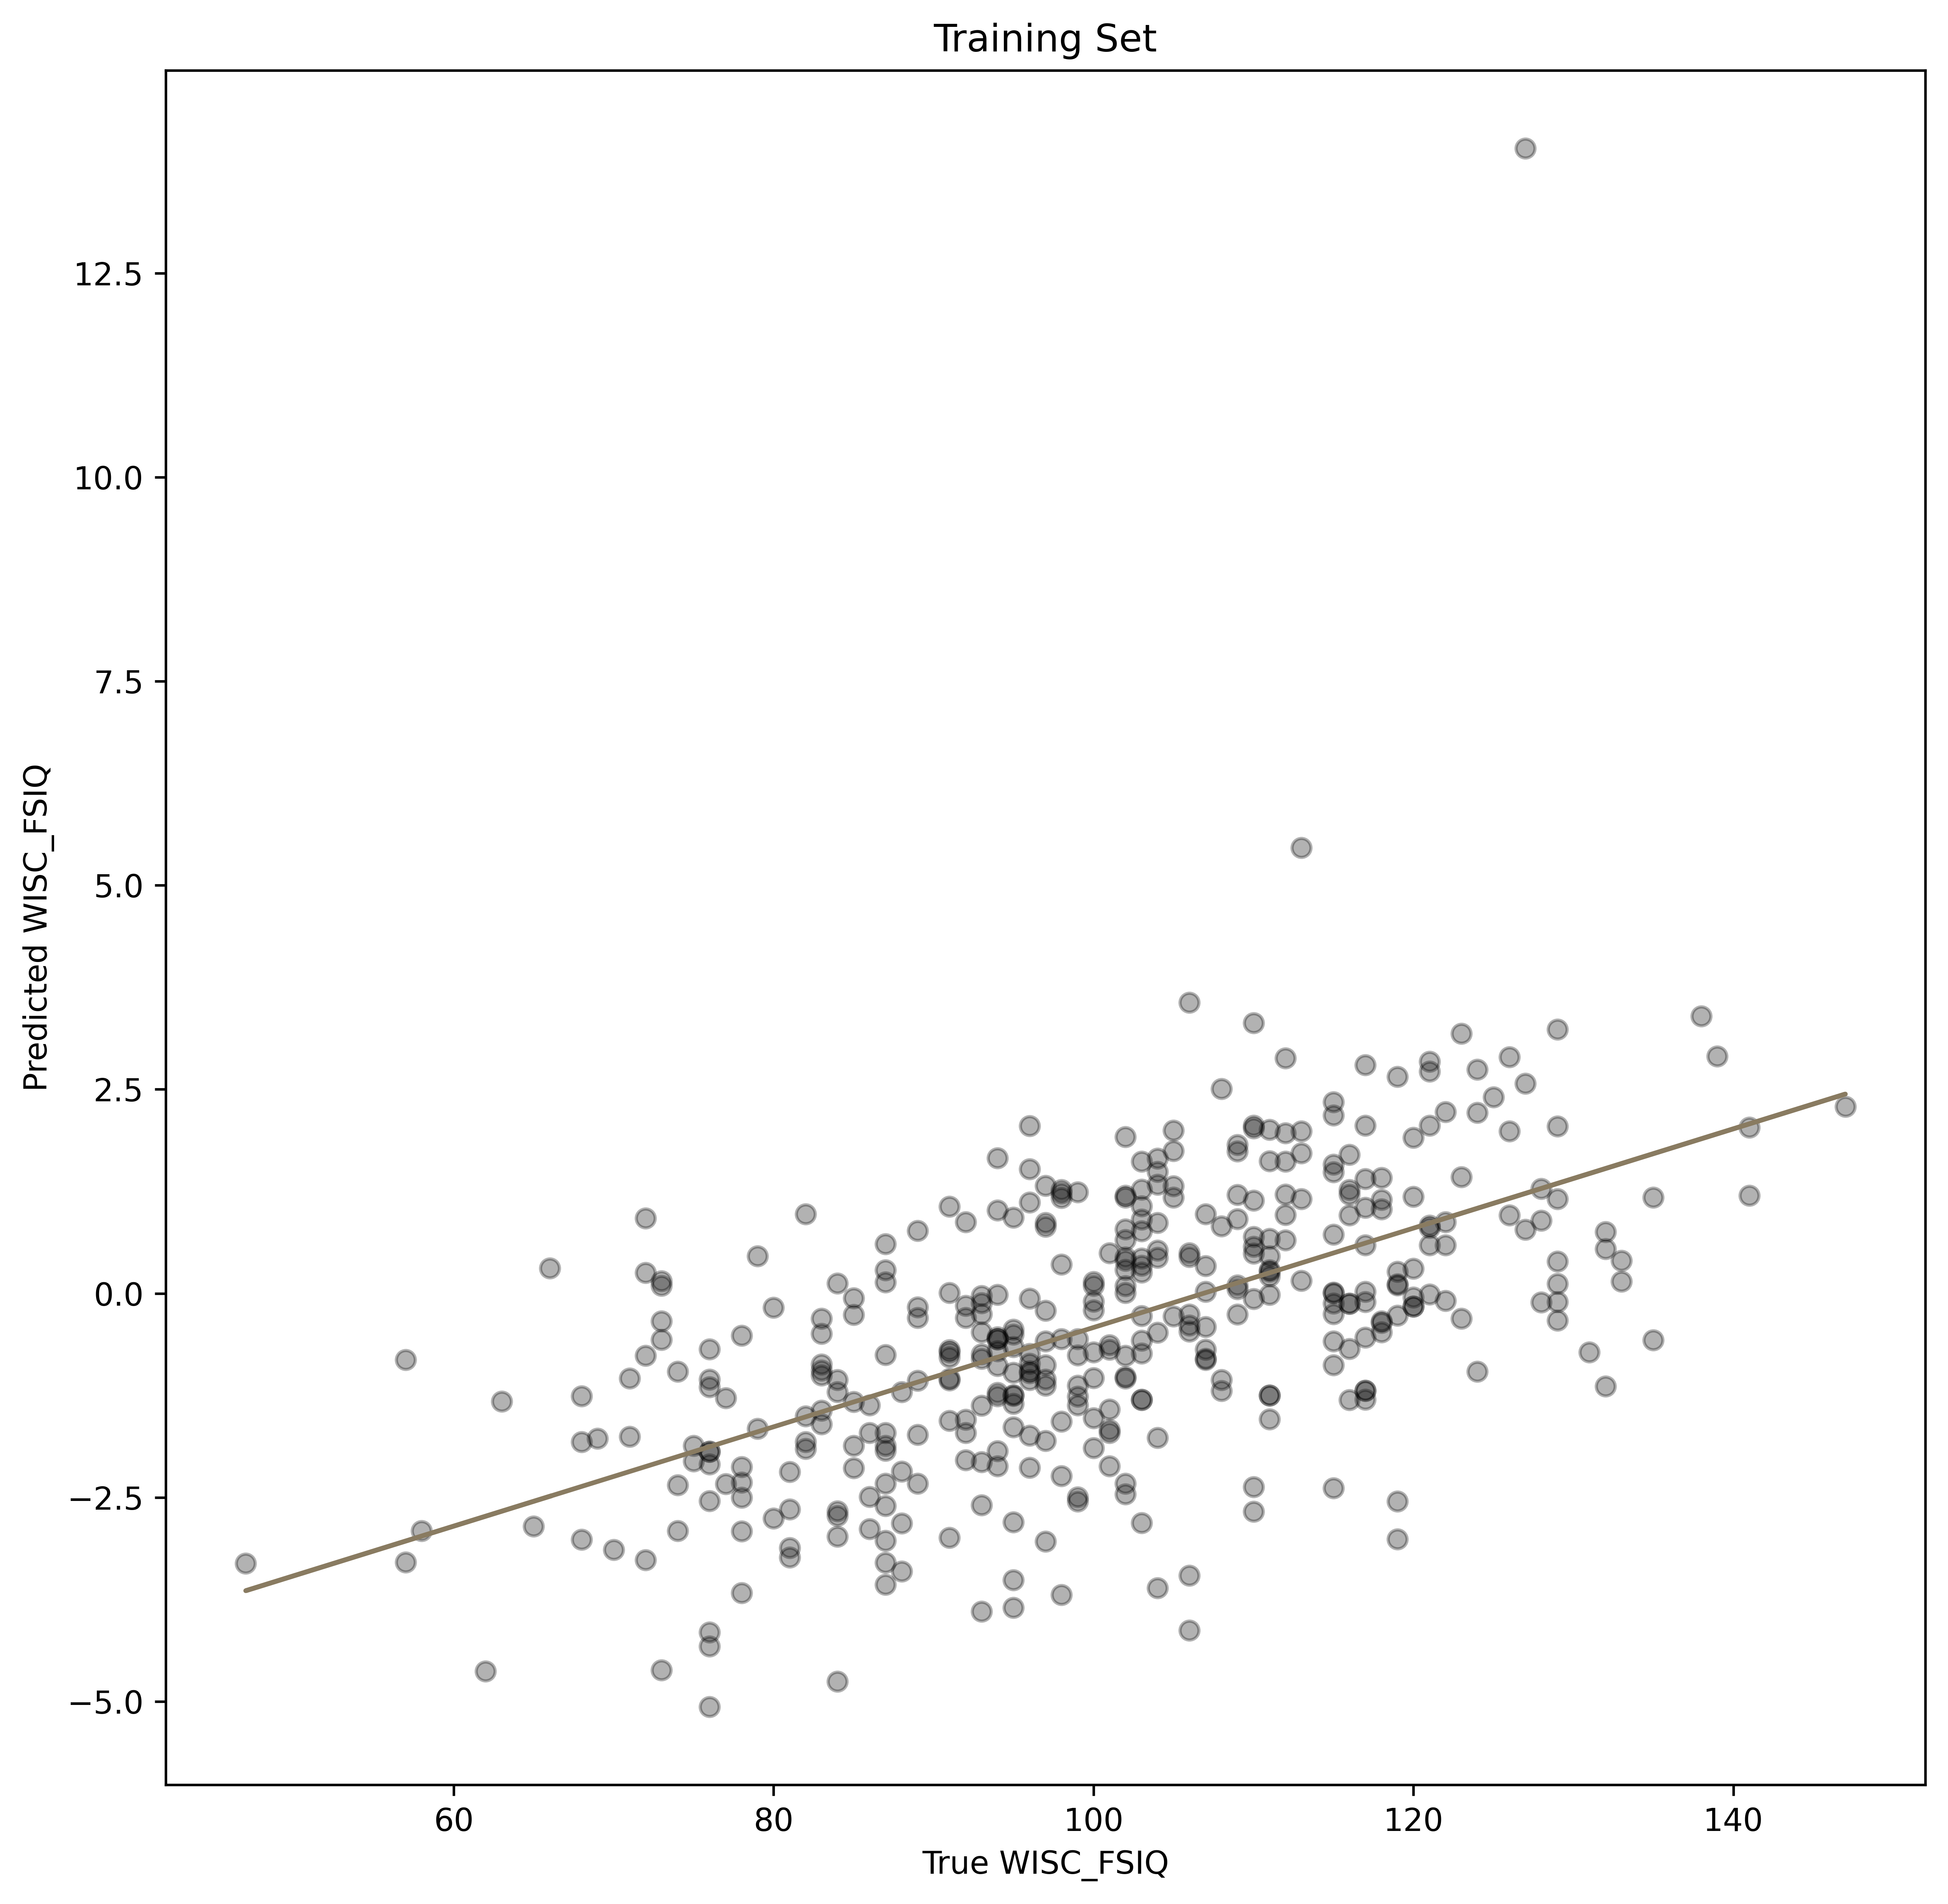

In [113]:
plt.figure(1, figsize=(10, 10), dpi=600)
plt.scatter(y_train, y_train_pred, alpha=0.3, color='black')
plt.plot(y_train, y_train_pred_lin_reg, color='#897B61')
plt.title("Training Set")
plt.xlabel(f'True {selected_measure}')
plt.ylabel(f'Predicted {selected_measure}')
# plt.annotate(f"r-squared = {avg_train_score:.3f}", (6, 16))
plt.show()

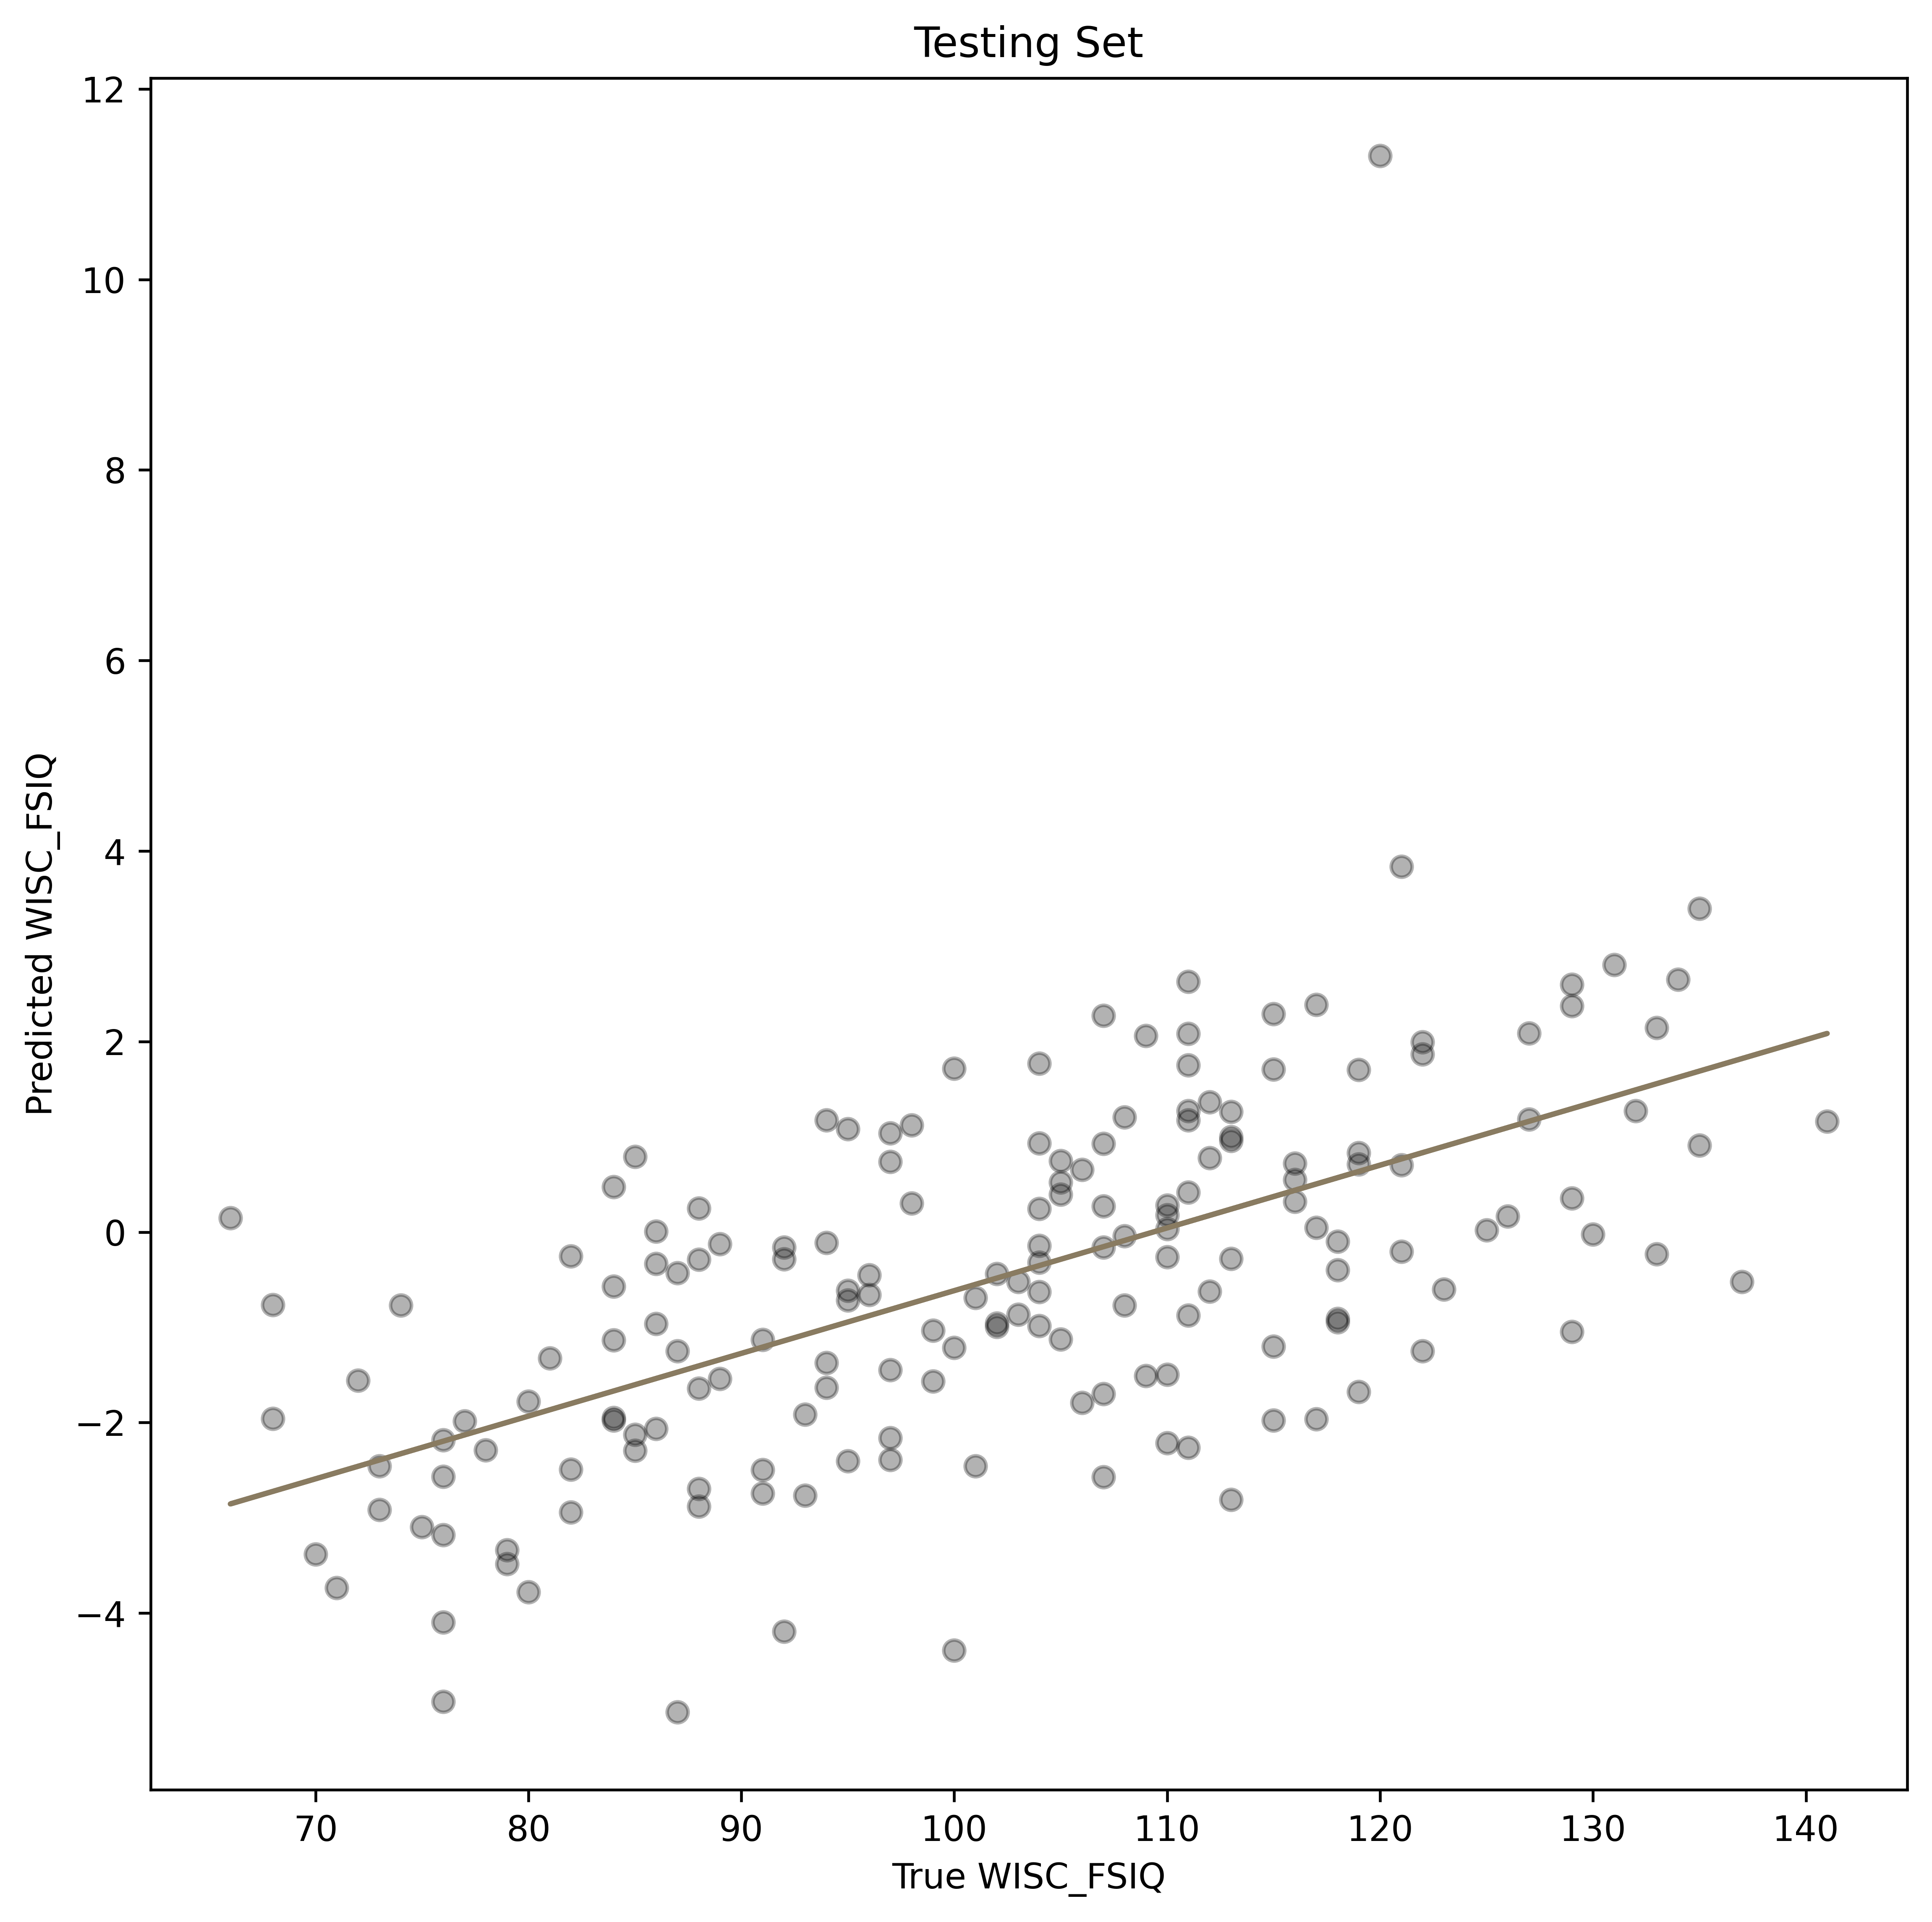

In [115]:
plt.figure(1, figsize=(9, 9), dpi=600)
plt.scatter(y_test, y_test_pred, alpha=0.3, color='black')
plt.plot(y_test, y_test_pred_lin_reg, color='#897B61')
plt.title("Testing Set")
plt.xlabel(f'True {selected_measure}')
plt.ylabel(f'Predicted {selected_measure}')
# plt.annotate(f"r-squared = {lin_reg_test_score:.2f}", (60, 87))
plt.show()

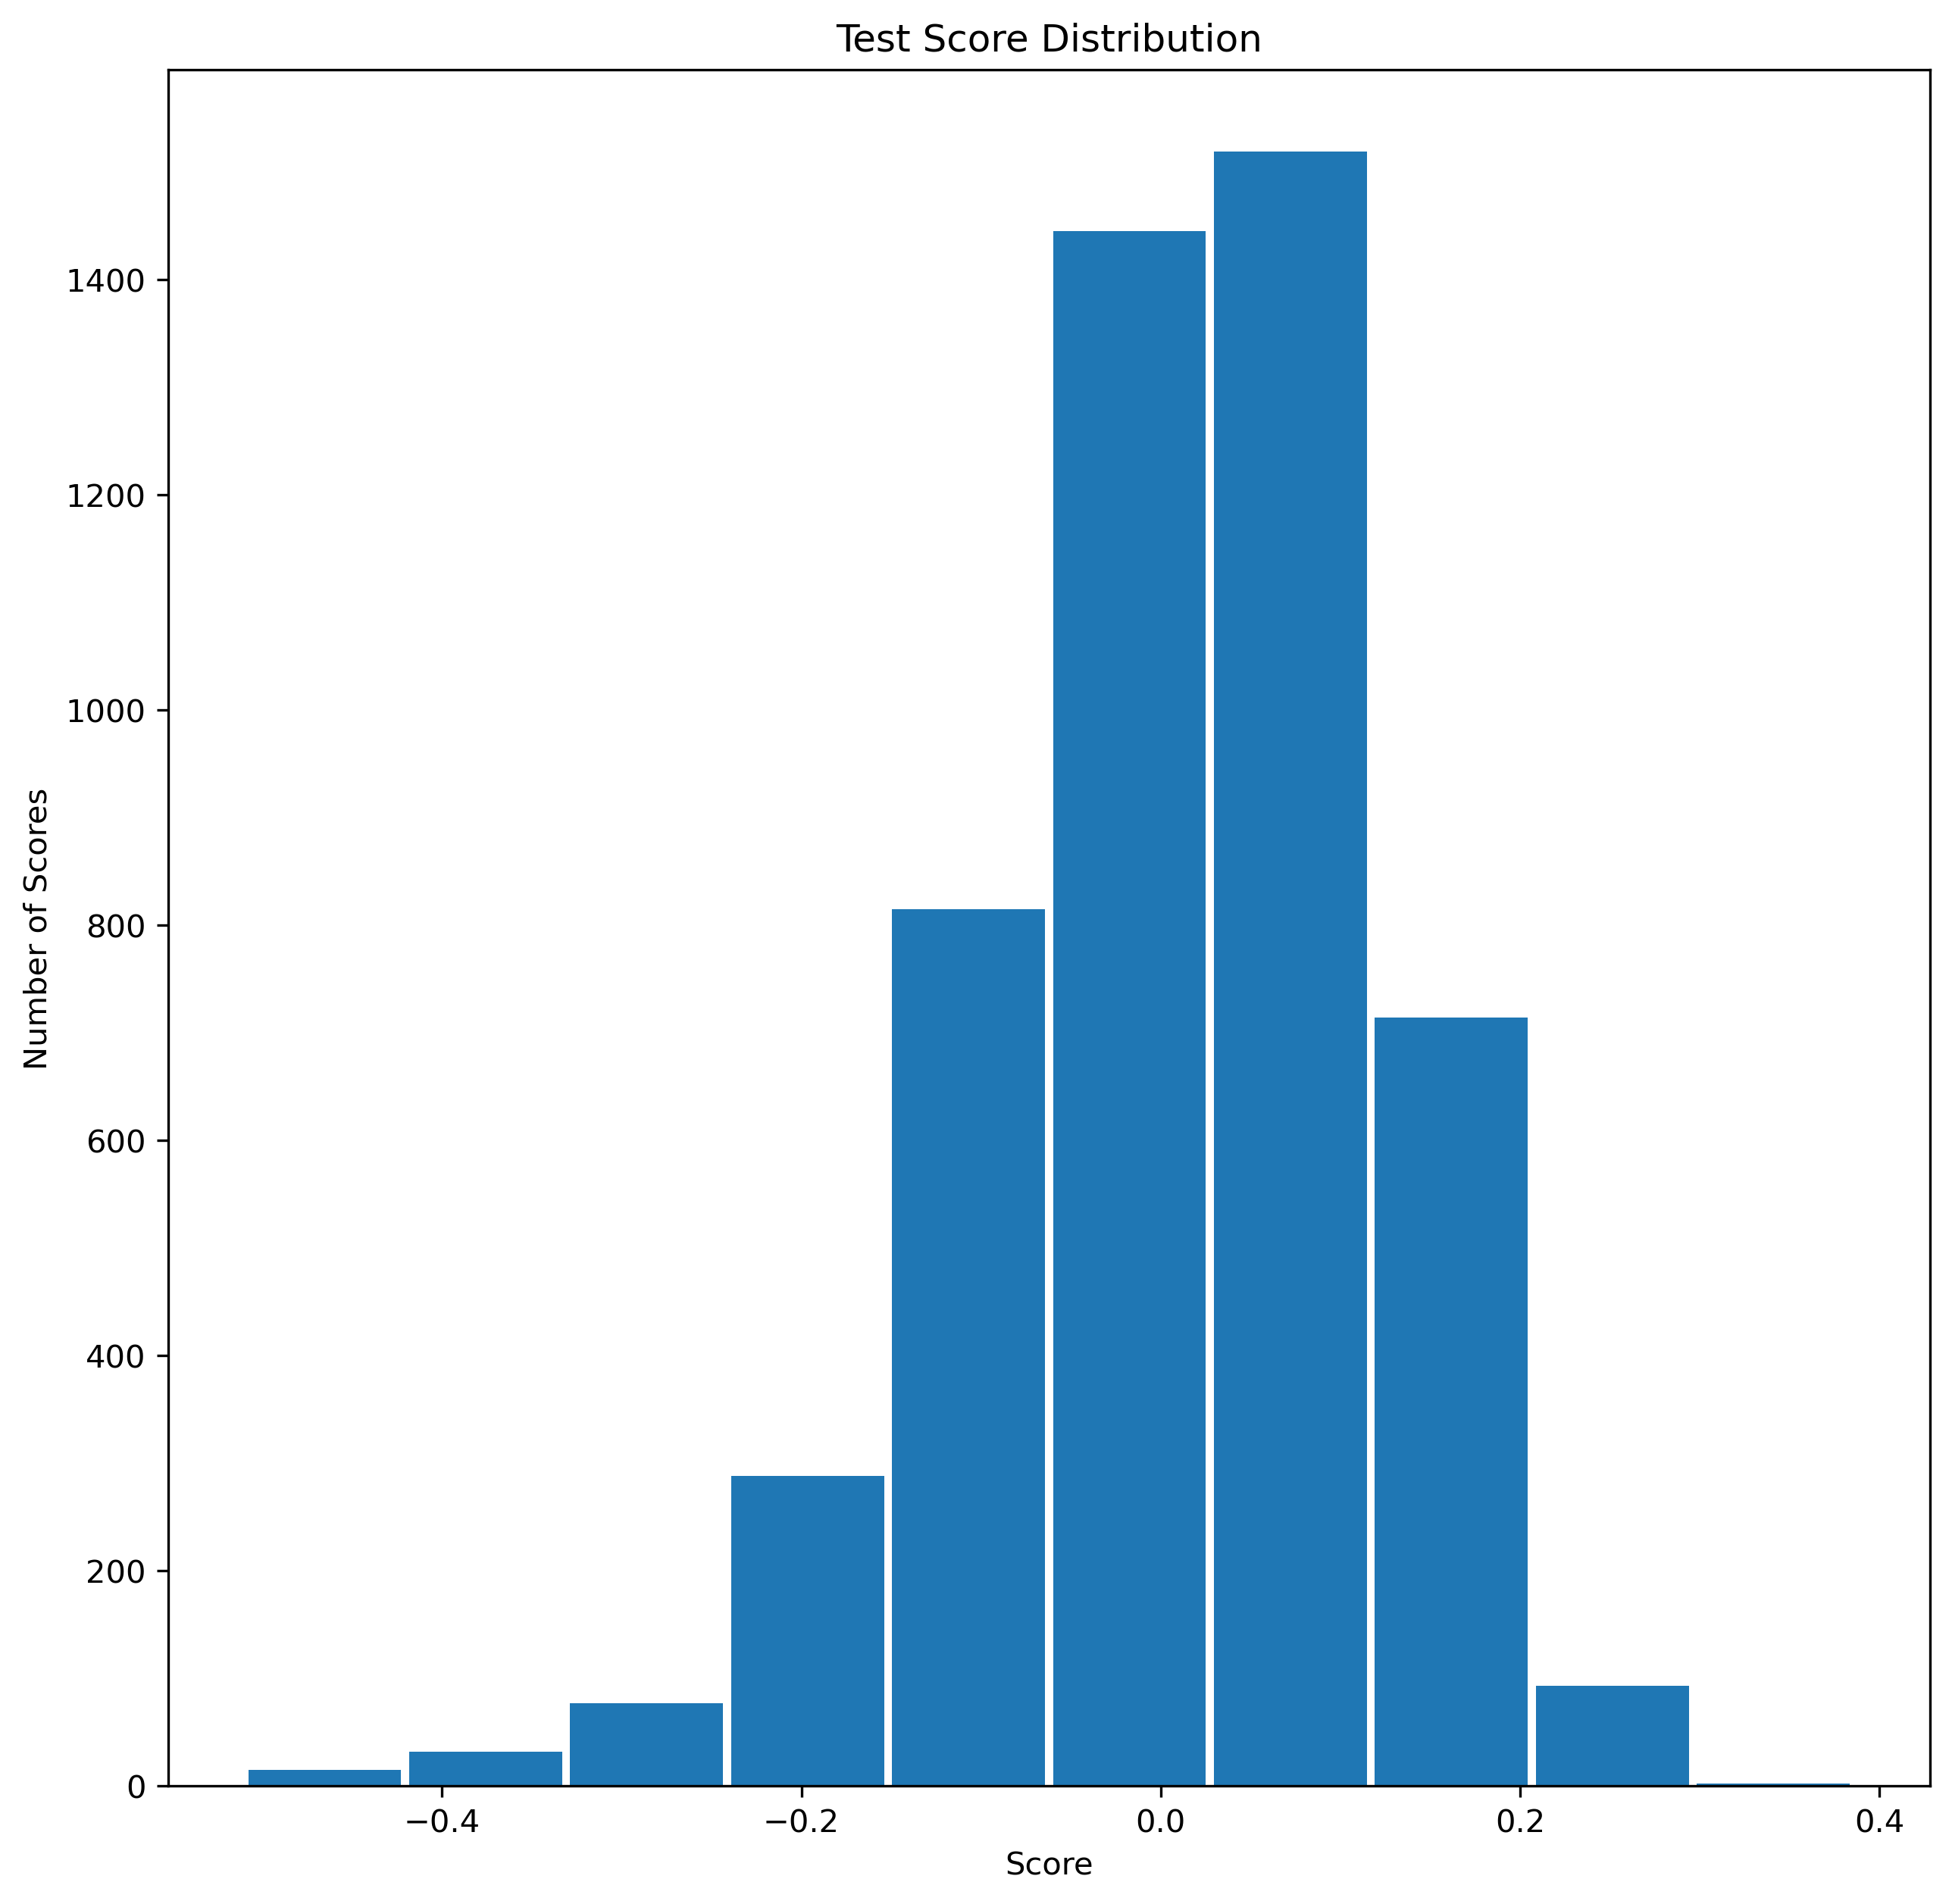

In [33]:
plt.figure(1, figsize=(10, 10))
plt.hist(x=test_scores, rwidth=0.95)
plt.title("Test Score Distribution")
plt.xlabel('Score')
plt.ylabel('Number of Scores')
plt.show()

**Plot PLS Coefficients**

(34716,) -0.20056007440330315 0.15924335729172281


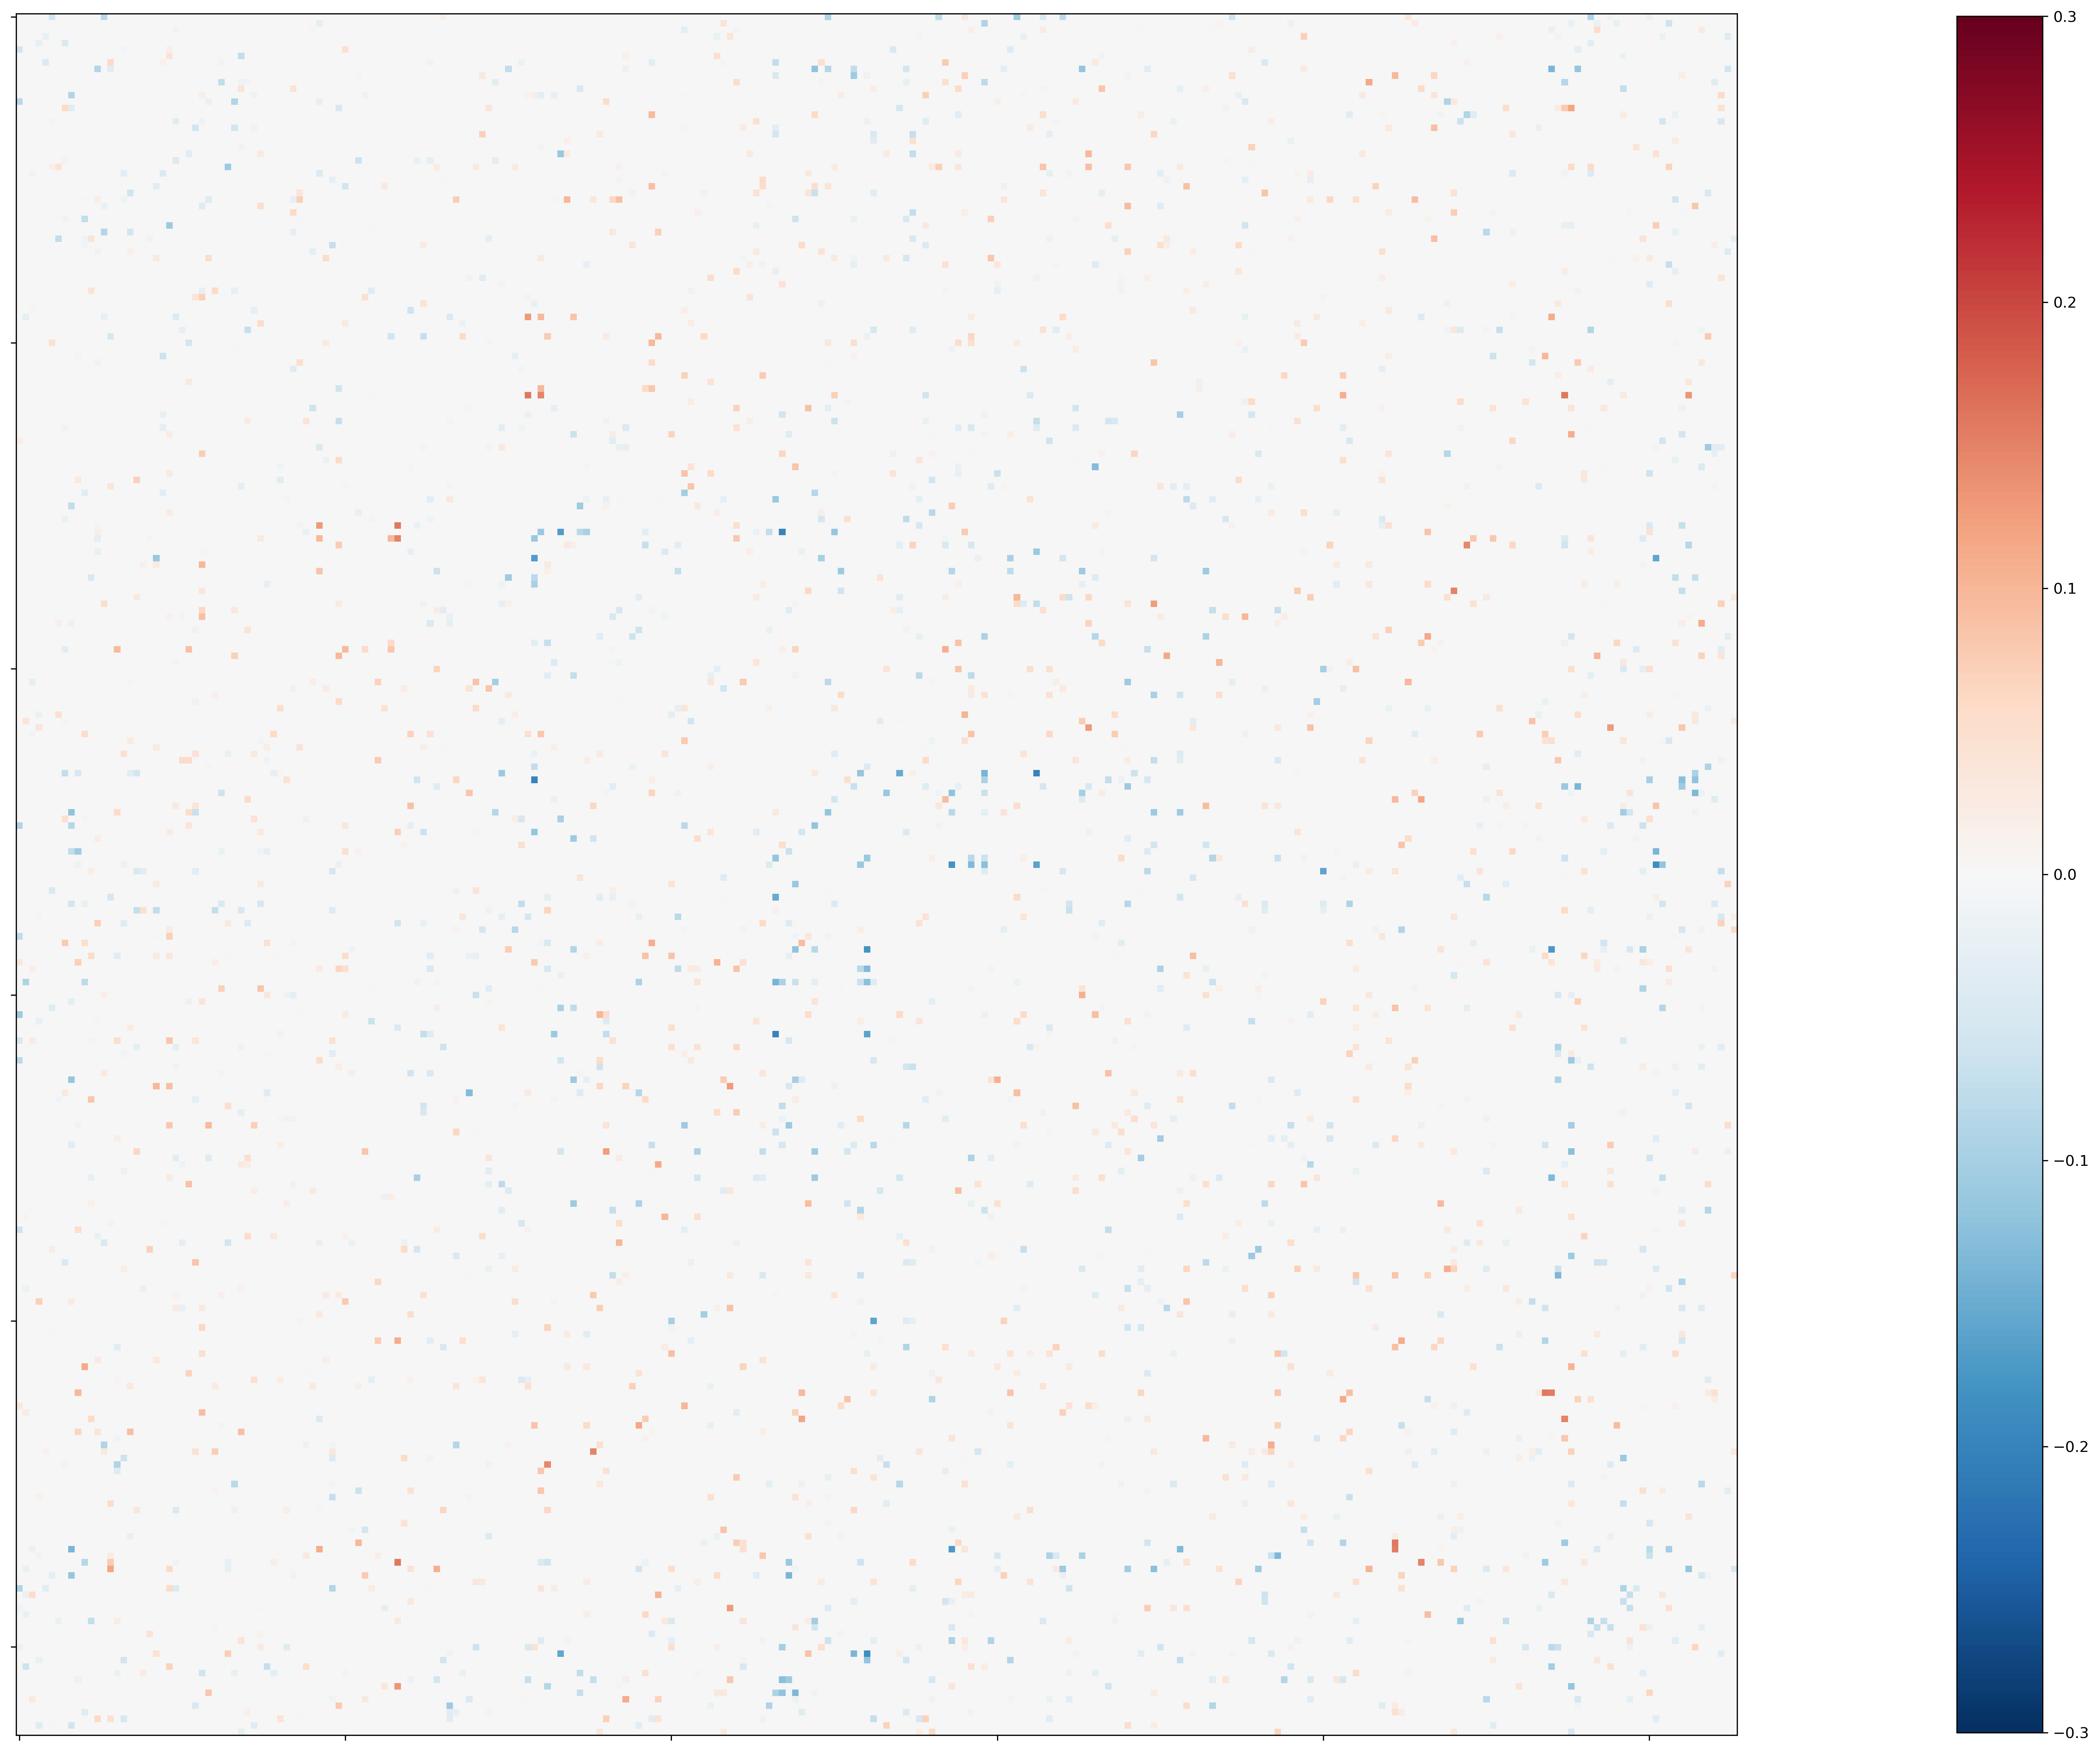

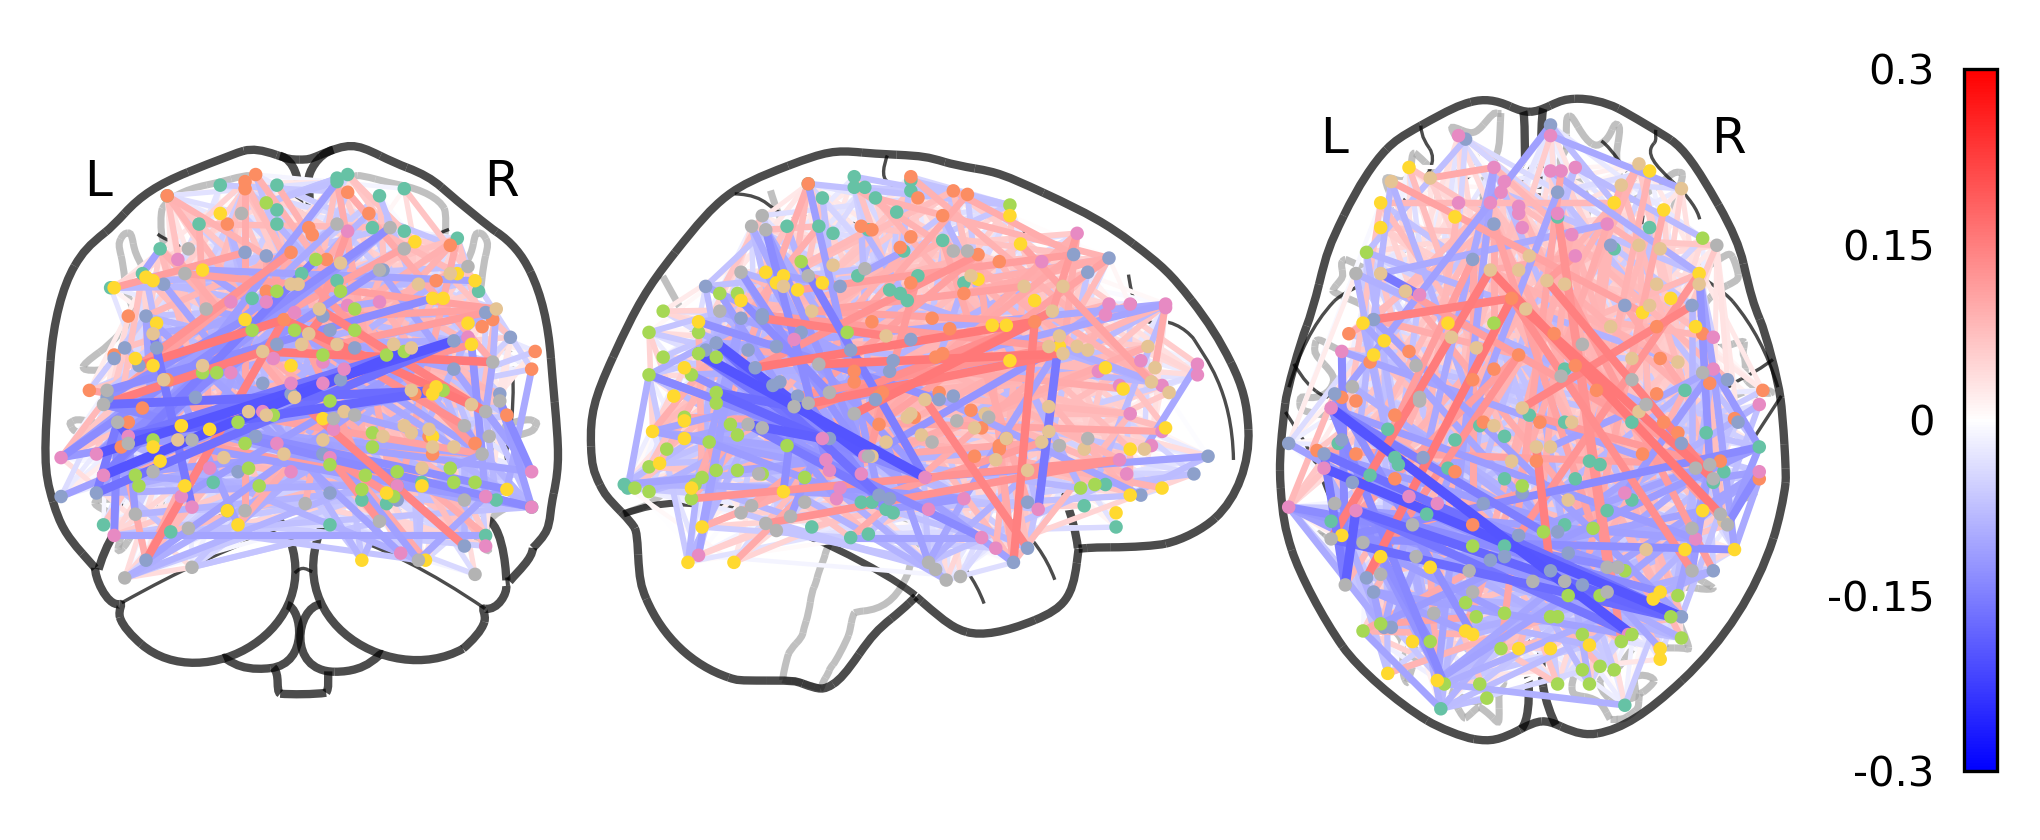

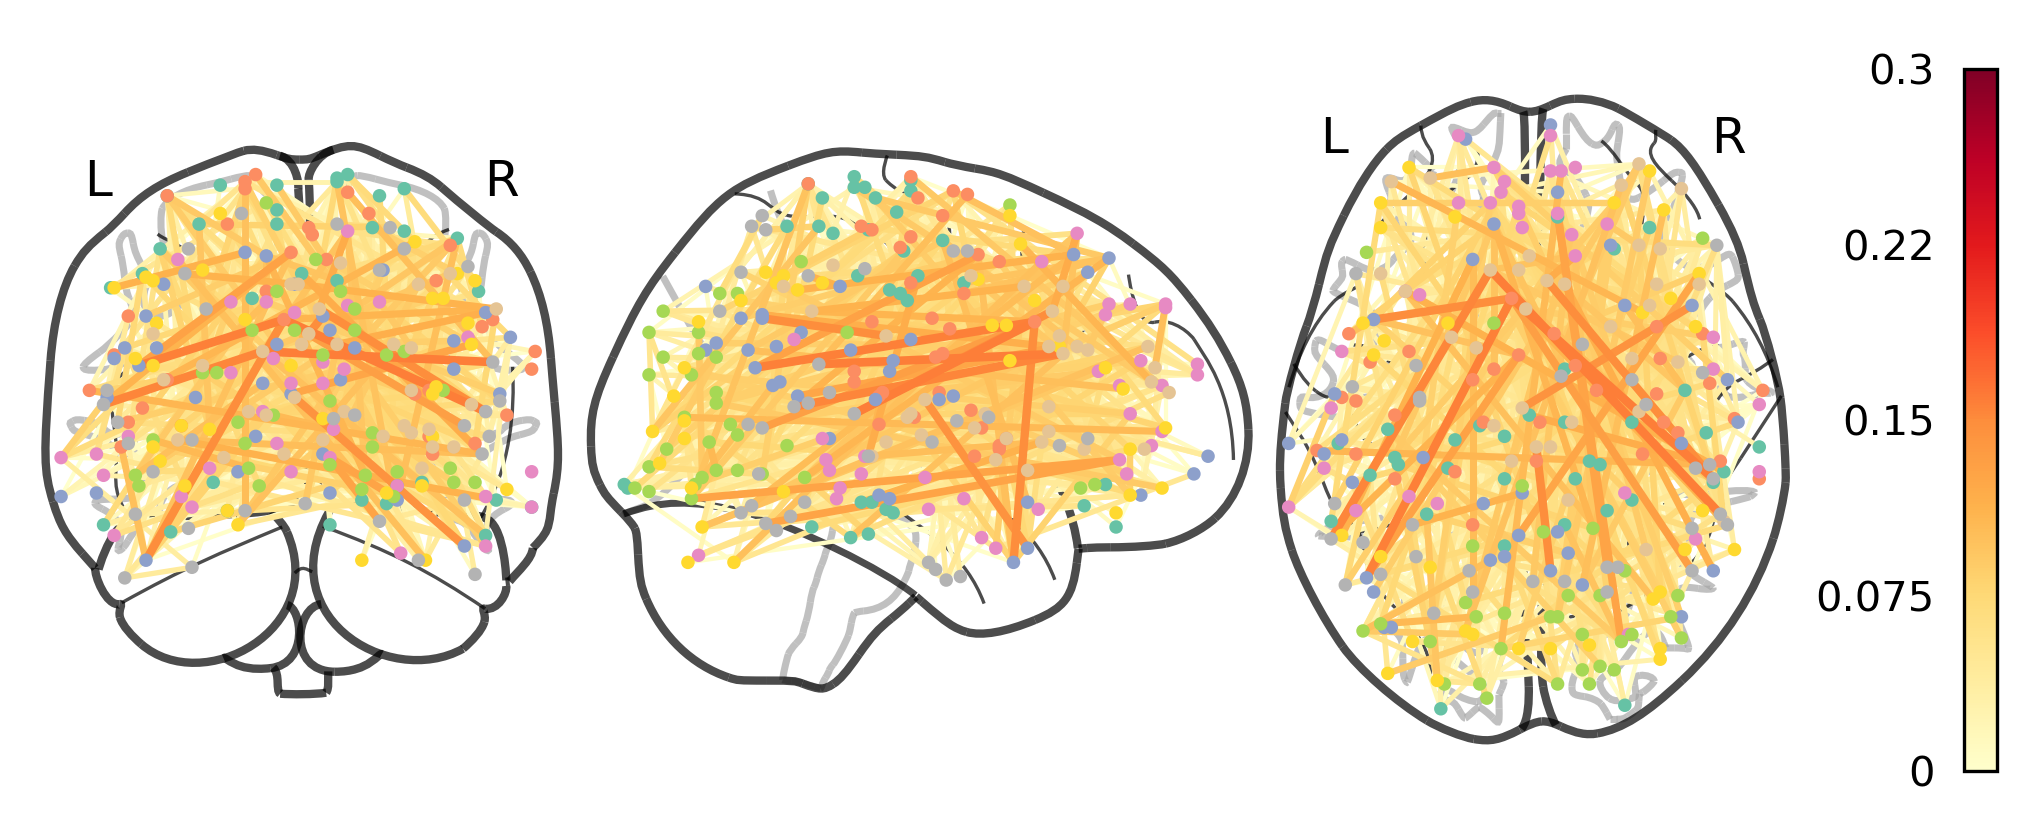

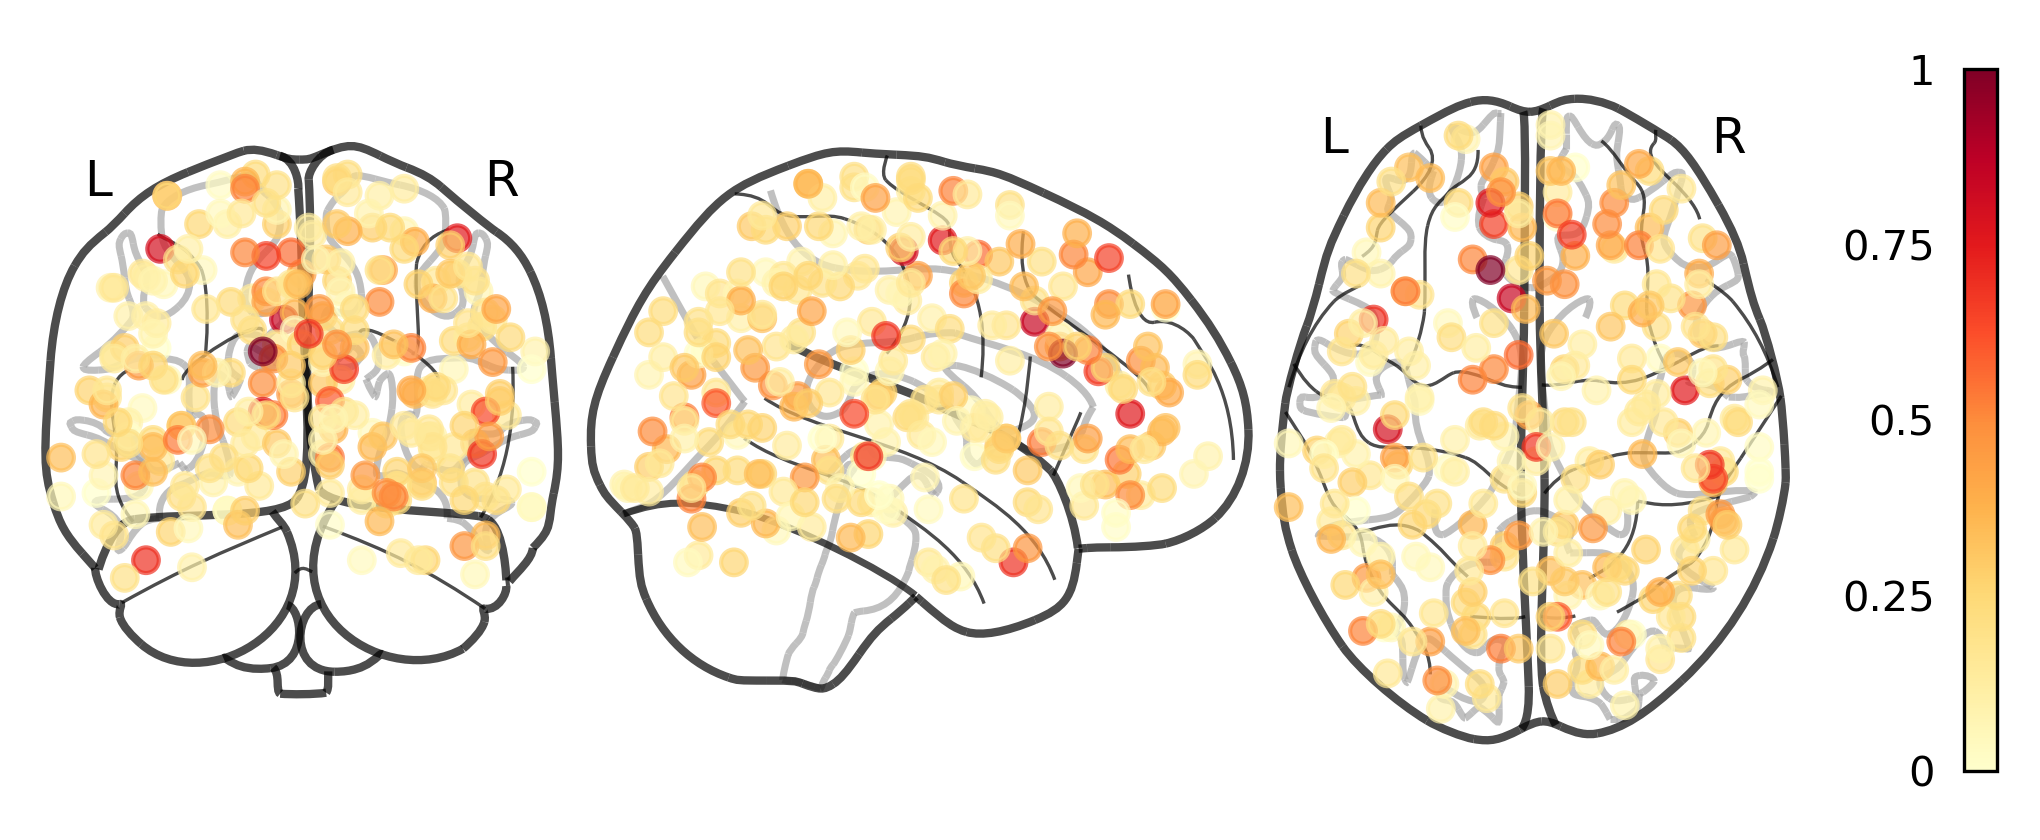

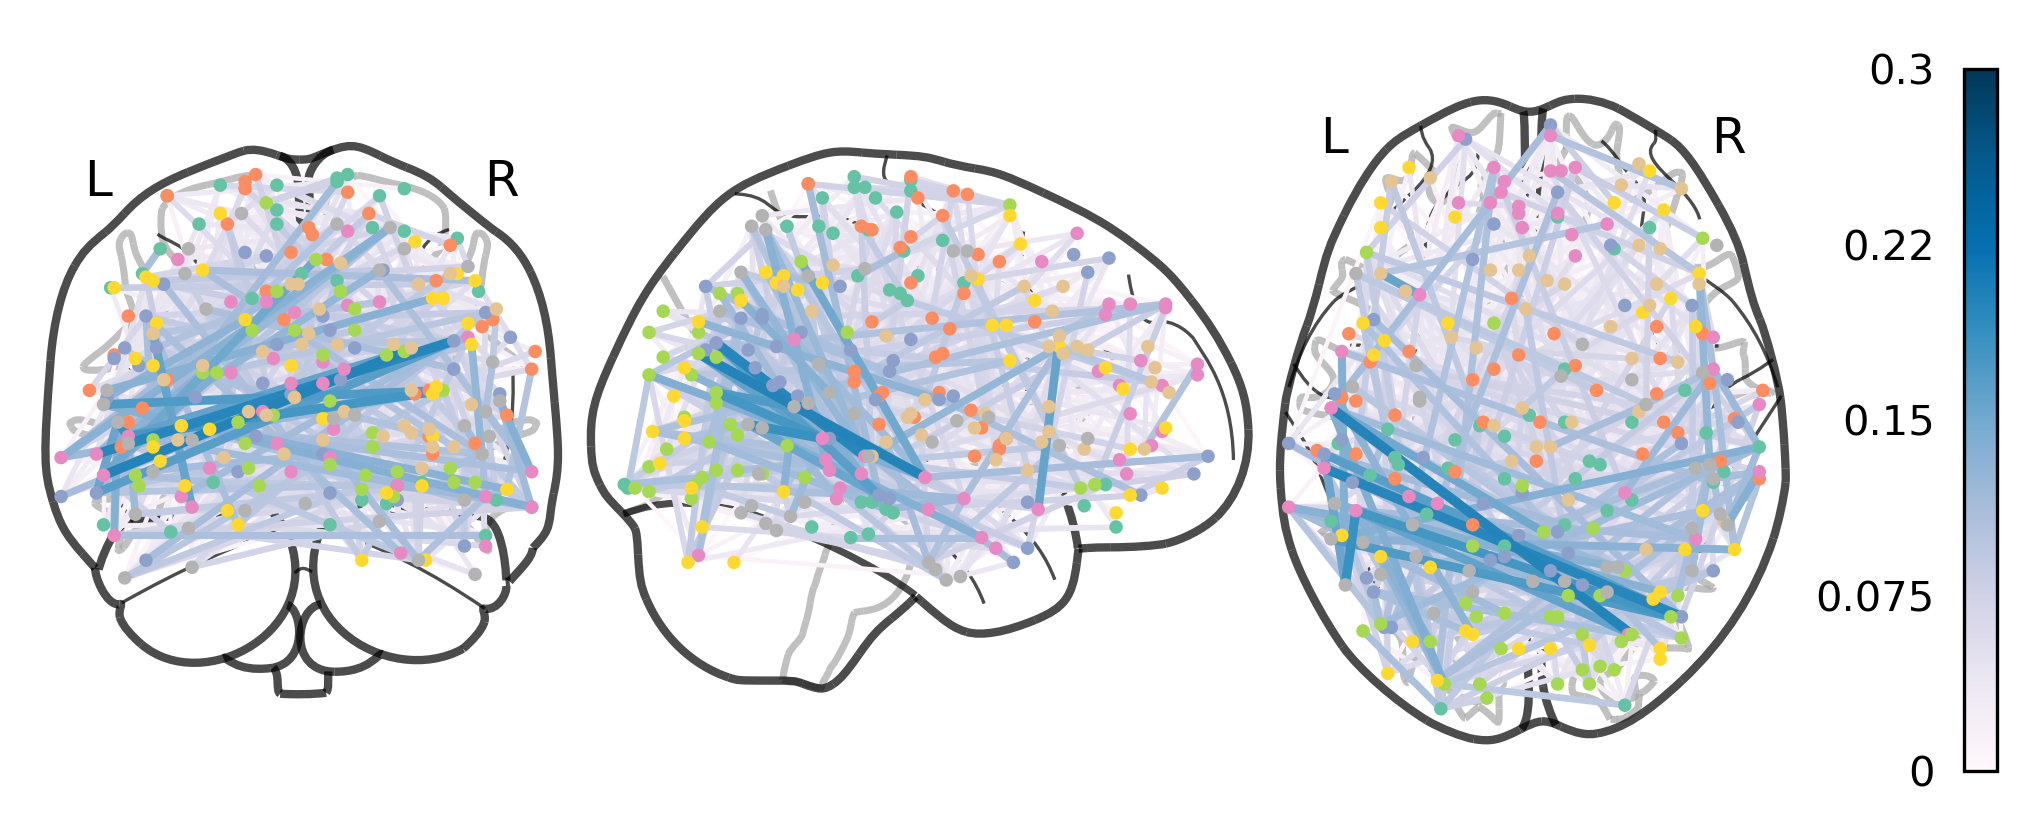

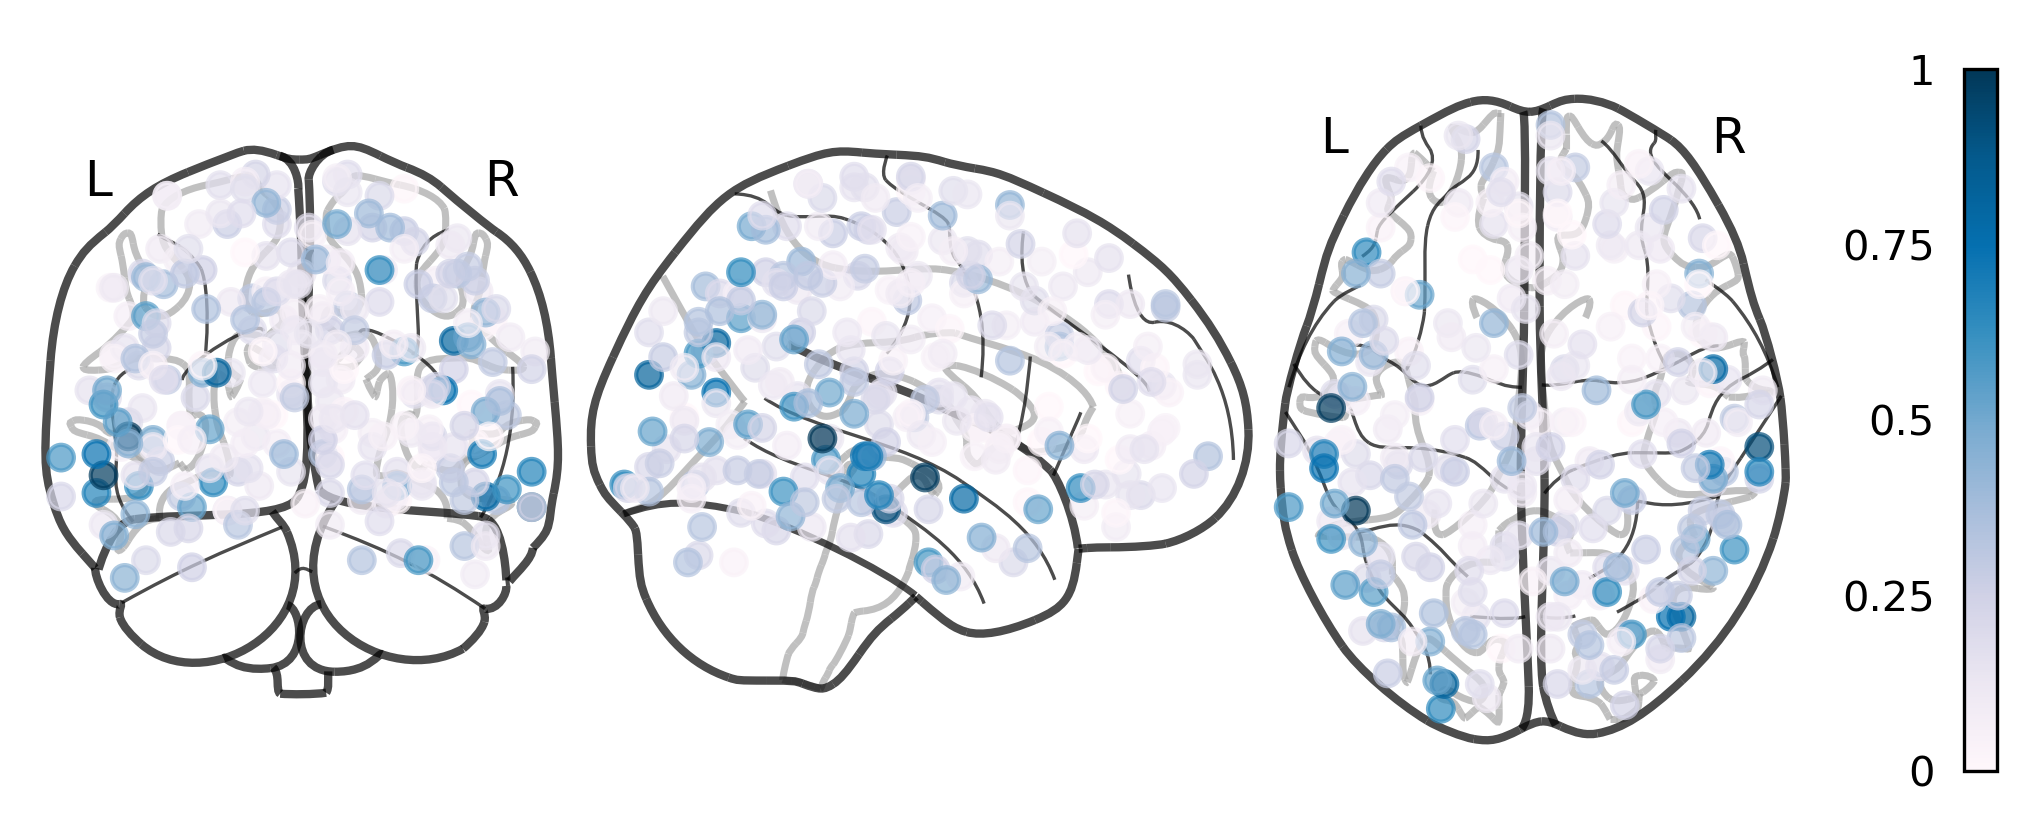

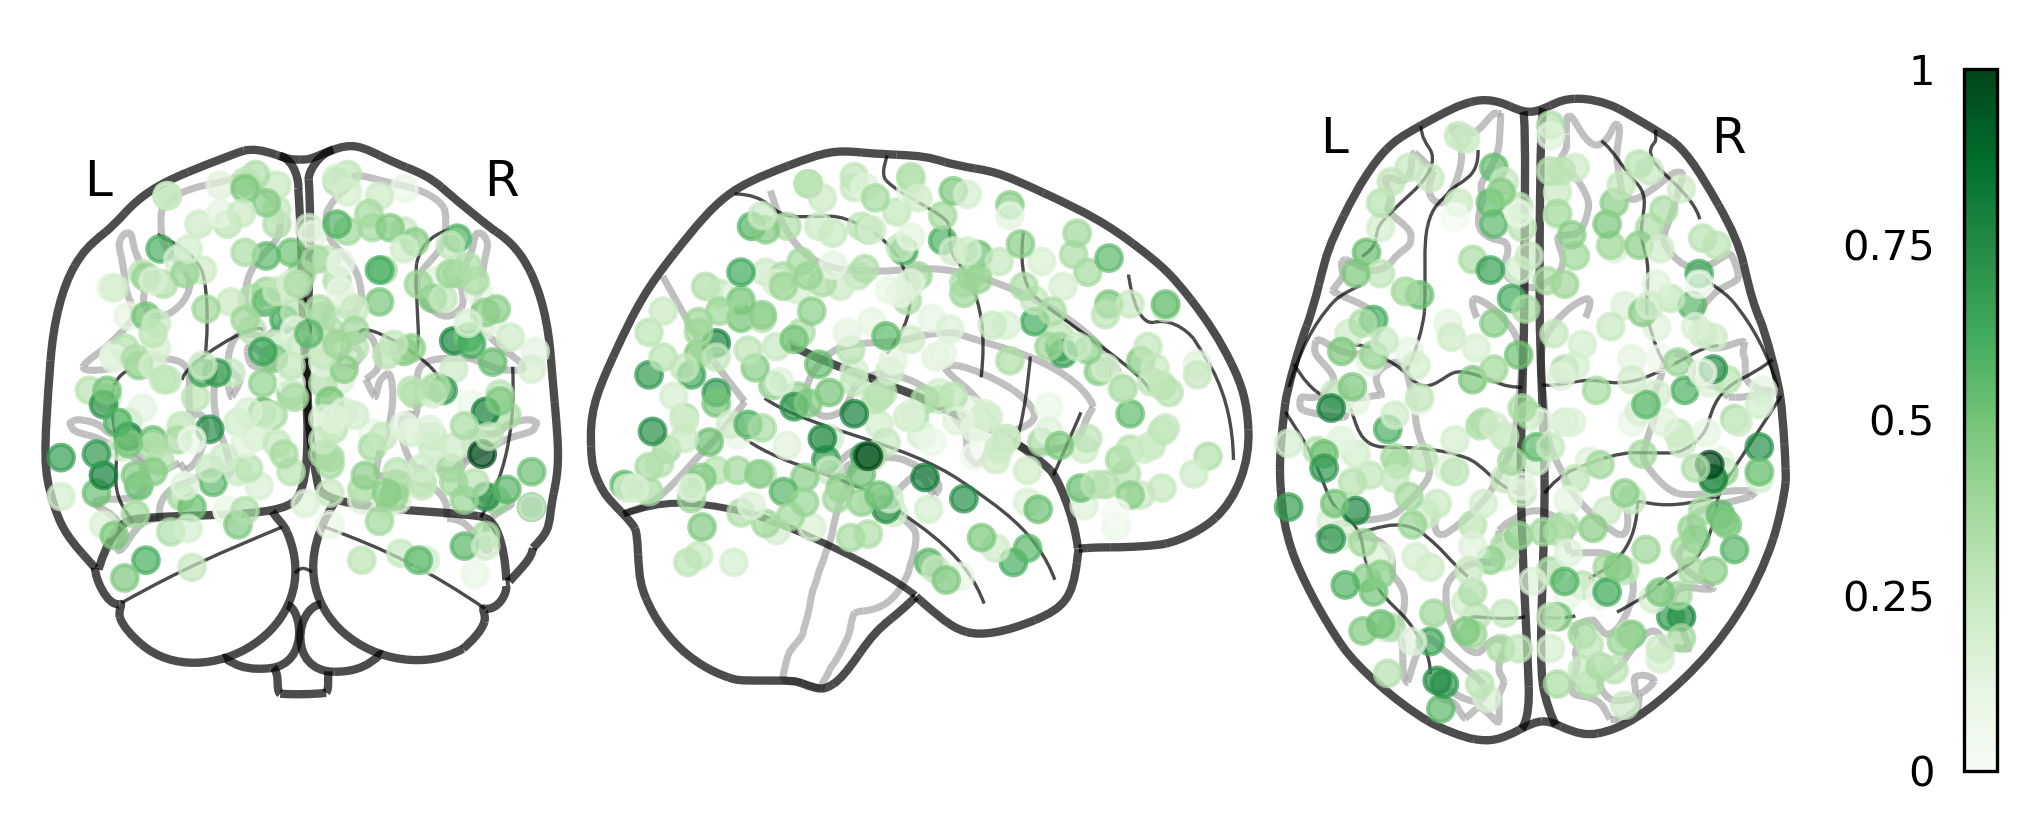

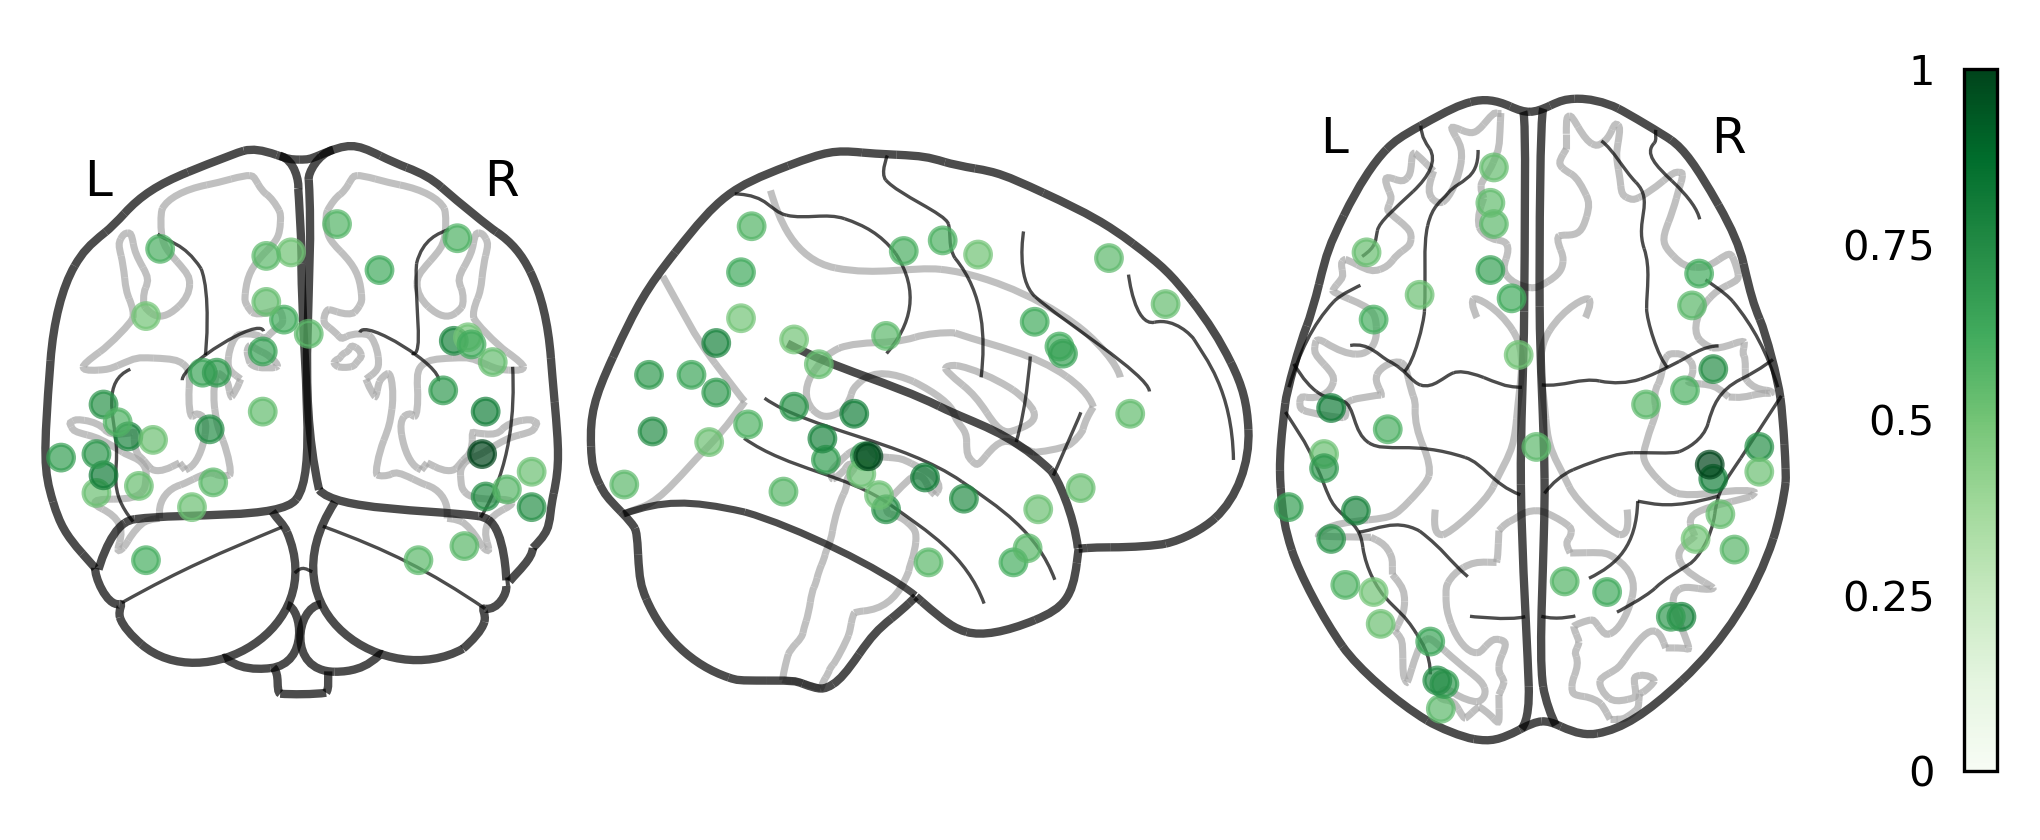

In [42]:
pls_coef = mi.inverse_transform(avg_coef.T)[0]
pls_coef_min = np.min(pls_coef)
pls_coef_max = np.max(pls_coef)
print(pls_coef.shape, pls_coef_min, pls_coef_max)

pls_coef_fc = create_power_fc_matrix(pls_coef)
vmin = -0.3
vmax = 0.3

plotting.plot_matrix(
    pls_coef_fc, colorbar=True, vmin=vmin, vmax=vmax, 
    figure=(20, 20))
plotting.plot_connectome(
    pls_coef_fc, coords, colorbar=True, edge_threshold=0, 
    node_size=5, edge_vmin=vmin, edge_vmax=vmax)

# clip connectivity matrix to preserve positive and negative edges
positive_edges = np.clip(pls_coef_fc, 0, pls_coef_max)
negative_edges = np.clip(pls_coef_fc, pls_coef_min, 0)

# calculate strength for positive edges
node_strength_positive = np.sum(np.abs(positive_edges), axis=0)
node_strength_positive /= np.max(node_strength_positive)

# calculate strength for negative edges
node_strength_negative = np.sum(np.abs(negative_edges), axis=0)
node_strength_negative /= np.max(node_strength_negative)

# plot nodes' strength for positive edges
plotting.plot_connectome(
    positive_edges, coords, colorbar=True, node_size=5,
    edge_vmin=0, edge_vmax=vmax, edge_cmap="YlOrRd")
plotting.plot_markers(
    node_strength_positive, coords, node_cmap="YlOrRd")

# plot nodes' strength for negative edges
plotting.plot_connectome(
    -negative_edges, coords, colorbar=True, node_size=5,
    edge_vmin=0, edge_vmax=vmax, edge_cmap="PuBu")
plotting.plot_markers(
    node_strength_negative, coords, node_cmap="PuBu")

node_strength = np.sum(np.abs(pls_coef_fc), axis=0)
node_strength /= np.max(node_strength)

plotting.plot_markers(
    node_strength, coords, node_threshold=0, node_vmin=0, 
    node_vmax=np.max(node_strength), node_cmap="Greens")
plotting.plot_markers(
    node_strength, coords, node_threshold=0.5, node_vmin=0, 
    node_vmax=np.max(node_strength), node_cmap="Greens")